<h1>Deep learning project 8DM20 CSMIA</h1>

<h4>Group members:</h4>
Attee <br>
Jolien <br>
Lieke <br>
Osman <br>
Tim Beishuizen - 0791613

In [27]:
# Import all used packages (unused packages are commented out so far)
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
#matplotlib inline
#import theano
#import lasagne
#import time
#import random
#random.seed(0)

Before every thing can be done, at first the data images have to be read and be made in useable data types.

In [28]:
# The function that loads the data
def loadData(data_set = 'test', image = '1st_manual'):
    
    # Check for the correct input
    if data_set != 'test' and data_set != 'training':
        raise Exception('Not the right data_set file')
    if image != '1st_manual' and image != '2nd_manual' and image != 'images' and image != 'mask':
        raise Exception('Not the right image file')
    if data_set == 'training' and image == '2nd_manual':
        raise Exception('File not available')
    
    # Project and image path
    project_path = os.getcwd()
    images_path = project_path +  '/8DM20_image_dataset/' + data_set + '/' + image + '/'
    
    images = []
    
    #Open image for image (20 in total for each of them)
    for i in range(1, 21):
        
        # Find correct image number
        image_nr = str(i)
        if data_set == 'training':
            image_nr = str(20 + i)
        elif len(image_nr) == 1:
            image_nr = '0' + image_nr
            
        # Specify path for this image
        if image == '1st_manual':
            image_path = images_path + image_nr + '_manual1.gif'
        elif image == '2nd_manual':
            image_path = images_path + image_nr + '_manual2.gif'
        elif image == 'images':
            image_path = images_path + image_nr + '_' + data_set + '.tif'
        elif image == 'mask':
            image_path = images_path + image_nr + '_' + data_set + '_mask.gif'
        
        # Open and append the image to the image list
        images.append(Image.open(image_path))
    
    return images

#The function that makes matrices from the images
def imageToMatrix(images):
    
    image_matrices = []
    
    for image in images:
        image_matrix = np.asarray(image.convert('L'))
        image_matrices.append(image_matrix)
        
    return image_matrices

In [30]:
# All test image lists
test_manual1_images = loadData('test', '1st_manual')
test_manual2_images = loadData('test', '2nd_manual')
test_raw_images = loadData('test', 'images')
test_mask_images = loadData('test', 'mask')

# Making matrices of the test images to work with
test_manual1_matrices = imageToMatrix(test_manual1_images)
test_manual2_matrices = imageToMatrix(test_manual2_images)
test_raw_matrices = imageToMatrix(test_raw_images)
test_mask_matrices = imageToMatrix(test_mask_images)

# All training image lists
training_manual1_images = loadData('training', '1st_manual')
training_raw_images = loadData('training', 'images')
training_mask_images = loadData('training', 'mask')

# Making matrices of the training images to work with
training_manual1_matrices = imageToMatrix(training_manual1_images)
training_raw_matrices = imageToMatrix(training_raw_images)
training_mask_matrices = imageToMatrix(training_mask_images)


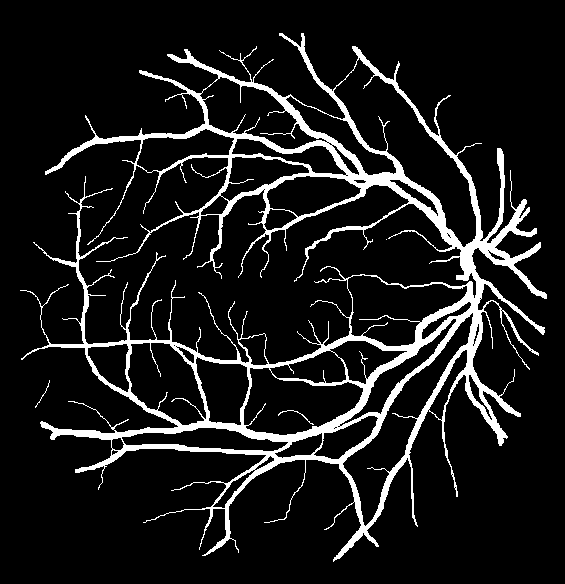

In [36]:
# If needed, this is the way to show everything graphically
plt.imshow(test_raw_matrices[1]) #For matrices (lower image)
test_manual1_images[1] #For images (upper image)


In [39]:
raw_matrix= test_raw_matrices[1]
mask_matrix = test_mask_matrices[1]

for i in range(raw_matrix.shape[0]):
    for j in range(raw_matrix.shape[1]):
                   if mask_matrix[i,j] == 0:
                       raw_matrix[i,j] = -1;

plt.imshow(raw_matrix)


ValueError: assignment destination is read-only